In [2]:
#Task 1
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.decomposition import PCA

Mounted at /content/drive
Number of PCA modes needed for 70% energy: 2
Number of PCA modes needed for 80% energy: 3
Number of PCA modes needed for 90% energy: 5
Number of PCA modes needed for 95% energy: 7


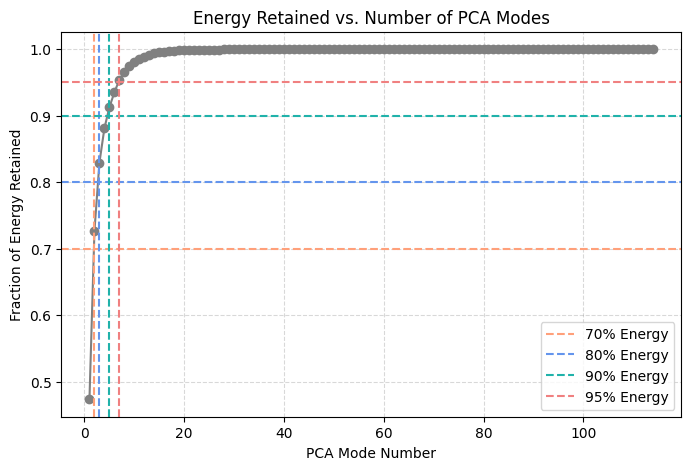

In [3]:
#Task 1
# Mount Google Drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/hw2data/train/'

# List of file paths
file_paths = ['walking_1.npy', 'walking_2.npy', 'walking_3.npy', 'walking_4.npy', 'walking_5.npy',
              'running_1.npy', 'running_2.npy', 'running_3.npy', 'running_4.npy', 'running_5.npy',
              'jumping_1.npy', 'jumping_2.npy', 'jumping_3.npy', 'jumping_4.npy', 'jumping_5.npy']

# Load all datasets and concatenate into X_train
X_train = [np.load(folder_path + file) for file in file_paths]
X_train = np.column_stack(X_train)  #(114, 1500) → (spatial, time-series)

#print(X_train.shape)

# Apply PCA (sklearn automatically centers data)
pca = PCA()
#coef, pcs_modes = pca.fit(X_train)
X_pca = pca.fit_transform(X_train.T)  # Fit PCA on transposed data (samples as rows)

# Extract singular values from explained variance
singular_values = np.sqrt(pca.explained_variance_ * (X_train.shape[1] - 1))

# Compute normalized energy (squared singular values)
E = np.power(singular_values, 2) / np.sum(np.power(singular_values, 2))

# Determine number of modes required for energy thresholds
thresholds = [0.7, 0.8, 0.9, 0.95]
num_modes = [-1] * len(thresholds)  # Stores mode numbers for each threshold

cumulative_energy = np.cumsum(E)  # Compute cumulative sum of energy

# Find the minimum number of PCA modes needed for each energy threshold
for i in range(len(E)):
    for j in range(len(thresholds)):
        if num_modes[j] == -1 and cumulative_energy[i] >= thresholds[j]:
            num_modes[j] = i + 1  # Mode index starts from 1

# Print required modes for each threshold
for threshold, mode_count in zip(thresholds, num_modes):
    print(f"Number of PCA modes needed for {threshold*100:.0f}% energy: {mode_count}")

# Plot cumulative energy
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(E) + 1), cumulative_energy, color='gray', marker='o', linestyle='-')

# Mark threshold lines
colors = ['lightsalmon', 'cornflowerblue', 'lightseagreen', 'lightcoral']
for i, (threshold, mode_count) in enumerate(zip(thresholds, num_modes)):
    plt.axhline(y=threshold, color=colors[i], linestyle='--', label=f'{int(threshold*100)}% Energy')
    plt.axvline(x=mode_count, color=colors[i], linestyle='--')

# Formatting the plot
plt.xlabel('PCA Mode Number')
plt.ylabel('Fraction of Energy Retained')
plt.title('Energy Retained vs. Number of PCA Modes')
plt.legend()
plt.grid(True, linestyle='--', color='gray', alpha=0.3)
plt.show()


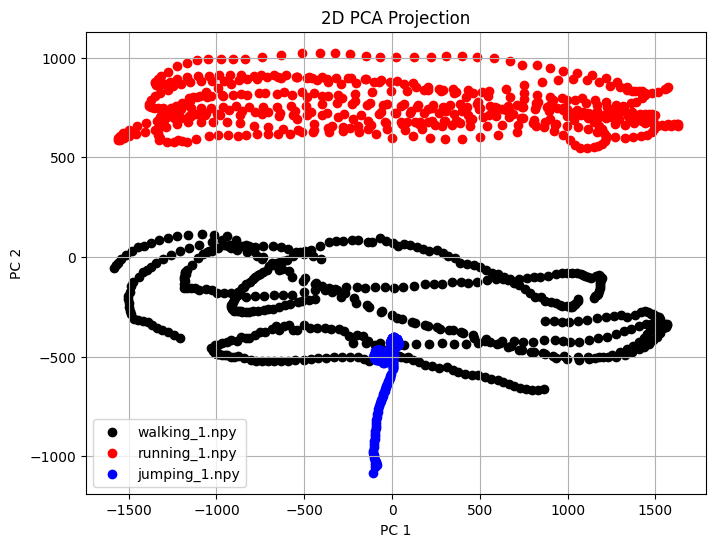

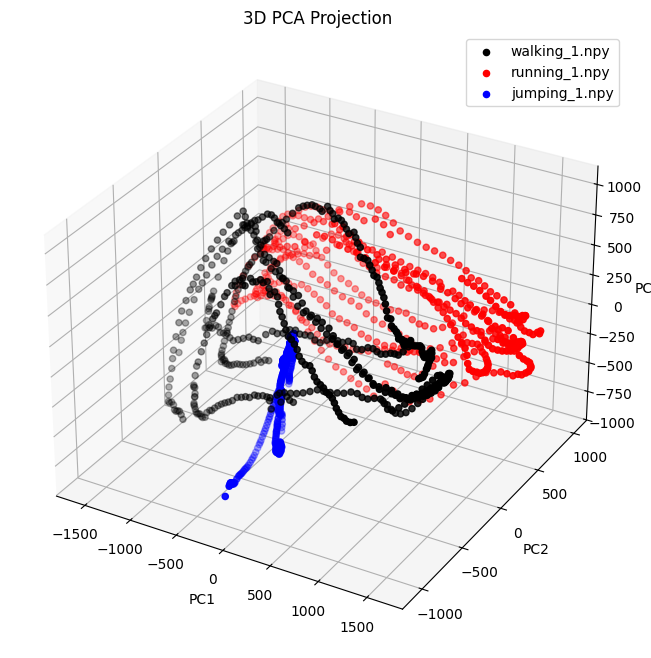

In [6]:
#Task 2
from mpl_toolkits.mplot3d import Axes3D

# Truncate to 2 and 3 PCA modes
X_pca_2 = X_pca[:, :2]  # First 2 principal components
X_pca_3 = X_pca[:, :3]  # First 3 principal components
#print(X_pca_2.shape)
#print(X_pca_3)

# Plot PCA projection for 2 modes
plt.figure(figsize=(8, 6))
# Define colors for different movements
colors = ['black'] * 5 + ['red'] * 5 + ['blue'] * 5  # Walking (black), Running (red), Jumping (blue)
for i in range(len(file_paths)):
    plt.scatter(X_pca_2.T[0, i * 100:(i + 1) * 100], X_pca_2.T[1, i * 100:(i + 1) * 100],
                color=colors[i], label=file_paths[i] if i % 5 == 0 else "")

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('2D PCA Projection')
plt.grid()
plt.legend()
plt.show()

#3D PCA Plot (PC1 vs. PC2 vs. PC3)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(file_paths)):
    ax.scatter(X_pca_3.T[0, i * 100:(i + 1) * 100], X_pca_3.T[1, i * 100:(i + 1) * 100], X_pca_3.T[2, i * 100:(i + 1) * 100],
               color=colors[i], label=file_paths[i] if i % 5 == 0 else "")

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Projection')
ax.legend()
plt.show()

In [7]:
# Task 3: Ground Truth Labels and Centroids

# Create Ground Truth Labels
# Assign labels: 0 (walking), 1 (jumping), 2 (running), 5 files * 100 samples each
ground_truth_labels = np.array([0] * 500 + [1] * 500 + [2] * 500)

# Compute Centroids in 3-modes PCA Space
k = 3
X_pca_k = X_pca[:, :k]  # Truncate to first k PCA modes

centroids = {}

# Compute centroids for each class
for class_label in [0, 1, 2]:
    class_data = X_pca_k[ground_truth_labels == class_label]

    centroid = np.mean(class_data, axis=0)

    centroids[class_label] = centroid

# Print centroids
for class_label, centroid in centroids.items():
    print(f"Centroid for class {class_label}: {centroid}")


Centroid for class 0: [ -36.88211143 -253.35282541  175.91202104]
Centroid for class 1: [  60.77197779  752.7210869  -103.41194553]
Centroid for class 2: [ -23.88986635 -499.36826149  -72.5000755 ]


In [11]:
#Task 4 & 5
from sklearn.metrics import accuracy_score

k_values = [2,3,5,7,8,9]

test_file = '/content/drive/MyDrive/hw2data/test/'

# List of file paths
test_paths = ['walking_1t.npy', 'running_1t.npy', 'jumping_1t.npy']

# Load all datasets and concatenate into X_train
X_test = [np.load(test_file + file) for file in test_paths]
X_test = np.column_stack(X_test)
#print(X_test.shape)
#print(X_train.shape)

test_ground_truth_labels = np.array([0] * 100 + [1] * 100 + [2] * 100)

test_accuracies = []
accuracies = []

# Iterate over k values
for k in k_values:
    X_pca_k = X_pca[:, :k]
    X_test_pca_k = pca.transform(X_test.T)[:, :k]

    # Recompute centroids for the current k
    centroids = {}
    for class_label in [0, 1, 2]:
        class_data = X_pca_k[ground_truth_labels == class_label]
        centroids[class_label] = np.mean(class_data, axis=0)

    # Compute trained labels
    trained_labels = []
    for sample in X_pca_k:
        distances = [np.linalg.norm(sample - centroids[class_label]) for class_label in [0, 1, 2]]
        trained_labels.append(np.argmin(distances))

    trained_labels = np.array(trained_labels)

    # Predict test labels
    tested_labels = []
    for i in X_test_pca_k:
        t_distances = [np.linalg.norm(i - centroids[class_label]) for class_label in [0, 1, 2]]
        tested_labels.append(np.argmin(t_distances))

    tested_labels = np.array(tested_labels)

    # Compute accuracy
    accuracy = accuracy_score(ground_truth_labels, trained_labels)
    accuracies.append(accuracy)

    test_accuracy = accuracy_score(test_ground_truth_labels, tested_labels)
    test_accuracies.append(test_accuracy)

    # Print accuracy for the current k
    print(f"Train Accuracy for k = {k}: {accuracy * 100:.2f}%")
    print(f"Test Accuracy for k = {k}: {test_accuracy * 100:.2f}%")

Train Accuracy for k = 2: 88.13%
Test Accuracy for k = 2: 98.33%
Train Accuracy for k = 3: 75.60%
Test Accuracy for k = 3: 92.33%
Train Accuracy for k = 5: 75.07%
Test Accuracy for k = 5: 91.67%
Train Accuracy for k = 7: 87.07%
Test Accuracy for k = 7: 94.33%
Train Accuracy for k = 8: 87.53%
Test Accuracy for k = 8: 93.00%
Train Accuracy for k = 9: 87.87%
Test Accuracy for k = 9: 94.33%
